Yuheng HUANG

29-187011



**1 Deterministic OLG model**

**1.1**

There are a series of policy functions $\left\{a'=g_{j}\left(a,\theta\right)\right\}_{j=1}^{J}$, and real numbers $K$, $N$, $C$, $r$, $w$ s.t.

1. Prices are set competitively, that is, $r=F_{K}-\delta$ and $w=F_{N}$

2. The policy functions solve household's optimization problems in each period

3. Aggregate resource constraint $F\left(K,N\right)=\delta K+C$

4. capital and labor market clear, that is, $K=\Sigma_{j}\mu_{j}a_{j}$, $N=\Sigma_{j}\mu_{j}\theta_{j}$ and $C=\Sigma_{j}\mu_{j}c_{j}$

5. Transversality condition $a_{J+1}\geqslant 0$

In [1]:
import numpy as np
import numba
import datetime
import matplotlib.pyplot as plt

In [2]:
alpha=0.36
delta=0.1
beta=1.01
j_max=60

In [3]:
@numba.njit
def olg_det(r, k, w, alpha, beta, delta, c, a):
    gc = np.empty(60, dtype=np.float64)
    
    dis = 0.
    c_agg = 0.
    for i in range(60):
        dis = (beta*(1+r)/(1+r))**i + dis
        c_agg = w / (1+r)**i + c_agg
    for j in range(60):
        gc[j] = (beta*(1+r))**j

    c[0] =  c_agg/dis
    c[1:60] = c[0] * gc[1:60]
    for l in range(60):
        a[l+1]=(1+r)*a[l] + w - c[l]
    return np.sum(a), a, c

In [4]:
c = np.empty(60, dtype=np.float64)
a = np.zeros(61, dtype=np.float64)
n = 60.

count = 0
err = 1.
r_up = 1.0
r_low = -0.1
r = 0.01

start = datetime.datetime.now()

while err >=1e-7 and count <= 100:
    k = ((r+delta)/alpha)**(1/(alpha-1))*n
    w = (1-alpha)*(k/n)**alpha
    kprime, a_fin, c_fin = olg_det(r, k, w, alpha, beta, delta, c, a)
    
    if kprime < k:
        r_low = r
    else:
        r_up = r
    r = 0.5*(r_up+r_low)
    
    err = np.abs(k-kprime)
    count += 1
    
end = datetime.datetime.now()
print(end-start)

0:00:00.612088


In [5]:
print('In the equilibrium, the wage is %4.3f,\nthe interest rate is %4.3f%%,\nand the capital-output ratio is %4.3f.'
      % (w, r*100, k/(k**alpha*n**(1-alpha))))

In the equilibrium, the wage is 1.264,
the interest rate is 0.743%,
and the capital-output ratio is 3.351.


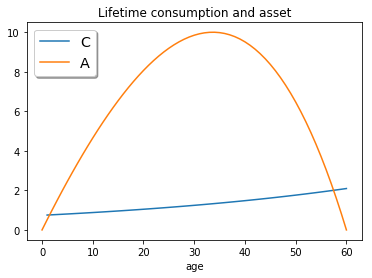

In [6]:
fig, ax = plt.subplots()
ax.plot(np.linspace(1,60,60), c_fin, label='C')
ax.plot(np.linspace(0,60,61), a_fin, label='A')
ax.set_title("Lifetime consumption and asset")
ax.set_xlabel('age')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()

**2 With retirement**

In [7]:
j_work = 45

In [8]:
@numba.njit
def olg_det_re(r, k, w, alpha, beta, delta, c, a, j_work):
    
    dis = 0.
    c_agg = 0.
    for i in range(60):
        dis = (beta*(1+r)/(1+r))**i + dis
        if i <=j_work-1:
            c_agg = w / (1+r)**i + c_agg
        
    c[0] =  c_agg/dis
    for j in range(59):
        c[j+1]=c[0] * (beta*(1+r))**(j+1)
    for l in range(60):
        if l >= j_work:
            a[l+1]=(1+r)*a[l] - c[l]
        else:
            a[l+1]=(1+r)*a[l] + w - c[l]
    return np.sum(a), a, c

In [9]:
c = np.empty(60, dtype=np.float64)
a = np.zeros(61, dtype=np.float64)
n = 45.

count = 0
err = 1.
r_up = 1.0
r_low = -0.1
r = 0.01

start = datetime.datetime.now()

while err >=1e-7 and count <= 100:
    k = ((r+delta)/alpha)**(1/(alpha-1))*n
    w = (1-alpha)*(k/n)**alpha
    kprime, a_fin, c_fin = olg_det_re(r, k, w, alpha, beta, delta, c, a, j_work)
    
    if kprime < k:
        r_low = r
    else:
        r_up = r
    r = 0.5*(r_up+r_low)
    
    err = np.abs(k-kprime)
    count += 1
    
end = datetime.datetime.now()
print(end-start)

0:00:00.214477


In [10]:
print('In the equilibrium with retirement,\nthe wage is %4.3f,\nthe interest rate is %4.3f%%,\nand the capital-output ratio is %4.3f.'
      % (w, r*100, k/(k**alpha*n**(1-alpha))))

In the equilibrium with retirement,
the wage is 1.442,
the interest rate is -1.508%,
and the capital-output ratio is 4.239.


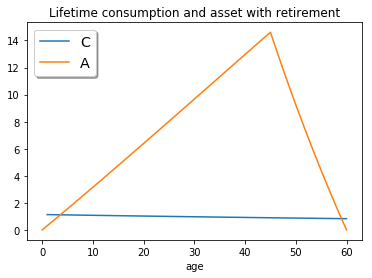

In [11]:
fig, ax = plt.subplots()
ax.plot(np.linspace(1,60,60), c_fin, label='C')
ax.plot(np.linspace(0,60,61), a_fin, label='A')
ax.set_title("Lifetime consumption and asset with retirement")
ax.set_xlabel('age')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()

**3 With retirement and social security**

In [12]:
ρ=0.5
τ=ρ*(j_max-j_work)/j_work

print('Given balanced budget of government and the value of ρ,\nthe tax rate is %1.2f%%.' % (τ*100))

Given balanced budget of government and the value of ρ,
the tax rate is 16.67%.


In [13]:
@numba.njit
def olg_det_re_ss(r, k, w, alpha, beta, delta, c, a, j_work,ρ,τ):
    
    dis = 0.
    c_agg = 0.
    for i in range(60):
        dis = (beta*(1+r)/(1+r))**i + dis
        if i <=j_work-1:
            c_agg = (1-τ)*w / (1+r)**i + c_agg
        else:
            c_agg = ρ*w / (1+r)**i + c_agg
        
    c[0] =  c_agg/dis
    for j in range(59):
        c[j+1]=c[0] * (beta*(1+r))**(j+1)
    for l in range(60):
        if l >= j_work:
            a[l+1]=(1+r)*a[l] + ρ*w - c[l]
        else:
            a[l+1]=(1+r)*a[l] + (1-τ)*w - c[l]
    return np.sum(a), a, c

In [14]:
c = np.empty(60, dtype=np.float64)
a = np.zeros(61, dtype=np.float64)
n = 45.

count = 0
err = 1.
r_up = 1.0
r_low = -0.1
r = 0.01

start = datetime.datetime.now()

while err >=1e-7 and count <= 100:
    k = ((r+delta)/alpha)**(1/(alpha-1))*n
    w = (1-alpha)*(k/n)**alpha
    kprime, a_fin, c_fin = olg_det_re_ss(r, k, w, alpha, beta, delta, c, a, j_work,ρ,τ)
    
    if kprime < k:
        r_low = r
    else:
        r_up = r
    r = 0.5*(r_up+r_low)
    
    err = np.abs(k-kprime)
    count += 1
    
end = datetime.datetime.now()
print(end-start)

0:00:00.231417


In [15]:
print('In the equilibrium with retirement and social security,\nthe wage is %4.3f,\nthe interest rate is %4.3f%%,\nand the capital-output ratio is %4.3f.'
      % (w, r*100, k/(k**alpha*n**(1-alpha))))

In the equilibrium with retirement and social security,
the wage is 1.312,
the interest rate is 0.045%,
and the capital-output ratio is 3.584.


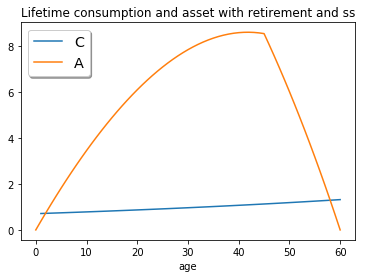

In [16]:
fig, ax = plt.subplots()
ax.plot(np.linspace(1,60,60), c_fin, label='C')
ax.plot(np.linspace(0,60,61), a_fin, label='A')
ax.set_title("Lifetime consumption and asset with retirement and ss")
ax.set_xlabel('age')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame()